# Frog–Fly 3D Reinforcement Learning Environment (PPO)

This environment simulates a frog navigating a bounded 3D space to catch a fly.  
The agent observes continuous-valued states, produces continuous 3D actions, and learns using PPO.

---

### Environment Definition

$$
\mathcal{S} = \{(x,y,z) \mid x,y,z \in [-1,1]\}
$$

At timestep \(t\):

$$
\mathbf{p}^{(t)}_f \in \mathcal{S}, \qquad 
\mathbf{p}^{(t)}_{\text{fly}} \in \mathcal{S}
$$

---

### Agent Dynamics

Action:

$$
\mathbf{a}_t \in [-1,1]^3
$$

Frog motion:

$$
\mathbf{p}^{(t+1)}_f =
\mathrm{clip}\!\left(\mathbf{p}^{(t)}_f + \alpha \cdot \mathbf{a}_t,\,
[-1,1]^3\right)
$$

Fly motion (stochastic):

$$
\mathbf{p}^{(t+1)}_{\text{fly}}=
\mathrm{clip}\!\left(
\mathbf{p}^{(t)}_{\text{fly}} +
v_{\text{fly}}\cdot\frac{\epsilon}{\|\epsilon\|},\,
[-1,1]^3\right),
\qquad
\epsilon\sim\mathcal{N}(0,I)
$$

---

### Observation Space

$$
\mathbf{s}_t =
[
\mathbf{p}^{(t)}_f,\,
\mathbf{p}^{(t)}_{\text{fly}},\,
\mathbf{p}^{(t)}_{\text{fly}}-\mathbf{p}^{(t)}_f,\,
PE(\mathbf{p}^{(t)}_f),\,
PE(\mathbf{p}^{(t)}_{\text{fly}})
]
$$

Positional encoding:

$$
PE(\mathbf{p}) =
[
\sin(\omega_k x),\cos(\omega_k x),\;
\sin(\omega_k y),\cos(\omega_k y),\;
\sin(\omega_k z),\cos(\omega_k z)
]_{k=1}^{K}
$$

---

### Action Space

$$
\mathcal{A} = [-1,1]^3
$$

The policy outputs a continuous displacement vector for movement.

---

### Reward Function

Distance:

$$
d_t = \|\mathbf{p}^{(t)}_{\text{fly}} - \mathbf{p}^{(t)}_{f}\|
$$

Reward shaping:

$$
r_t =
\begin{cases}
-\,d_t, & \text{not caught},\\[6pt]
10 - d_t, & \text{if } d_t < \delta.
\end{cases}
$$

Goal → minimize distance + catch fly efficiently.

---

# PPO Objective

Probability ratio:

$$
r_t(\theta) = 
\dfrac{\pi_\theta(a_t\,|\,s_t)}
      {\pi_{\theta_{\text{old}}}(a_t\,|\,s_t)}
$$

Advantage:

$$
A_t =
\sum_{k=0}^{T-t} \gamma^k r_{t+k} -
V_\phi(s_t)
$$

Clipped surrogate:

$$
J(\theta) =
\mathbb{E}_t \Big[
\min(
r_t(\theta)A_t,\,
\text{clip}(r_t(\theta),1-\epsilon,1+\epsilon)A_t
)\Big]
$$

Value loss:

$$
L_V(\phi)=\mathbb{E}_t[(V_\phi(s_t)-R_t)^2]
$$

Final optimization:

$$
\max_\theta J(\theta), \qquad \min_\phi L_V(\phi)
$$

---

### MDP Summary

| Element | Definition |
|---|---|
| State \(s_t\) | positions + relative vector + positional encodings |
| Action \(a_t\) | continuous 3D movement vector |
| Reward \(r_t\) | shaped distance + capture bonus |
| Goal | catch fly efficiently |
| Algorithm | PPO |



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

import gymnasium as gym
from gymnasium import spaces

import ray
from ray.rllib.algorithms.ppo import PPOConfig



In [2]:
def positional_encoding_3d(pos, num_freqs=4, max_freq=10.0):
    """
    pos: np.array shape (3,) with (x, y, z) in [-space_size, space_size].
    Returns: encoding vector of shape (3 * 2 * num_freqs,)
    """
    pos = np.asarray(pos, dtype=np.float32)
    assert pos.shape == (3,)

    freqs = np.linspace(1.0, max_freq, num_freqs)
    enc = []
    for coord in pos:            # x, y, z
        for f in freqs:
            enc.append(np.sin(f * coord))
            enc.append(np.cos(f * coord))
    return np.array(enc, dtype=np.float32)


class FrogFly3DEnv(gym.Env):
    """
    3D continuous environment:
    - Frog (agent) moves to catch a moving fly.
    - Observations: positions + relative vector + positional encodings.
    """
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, config=None):
        super().__init__()

        if config is None:
            config = {}

        self.space_size = float(config.get("space_size", 1.0))
        self.step_size = float(config.get("step_size", 0.1))
        self.fly_speed = float(config.get("fly_speed", 0.05))
        self.catch_radius = float(config.get("catch_radius", 0.15))
        self.max_steps = int(config.get("max_steps", 200))
        self.num_freqs = int(config.get("num_freqs", 4))
        self.use_positional_encodings = bool(
            config.get("use_positional_encodings", True)
        )

        # Action = 3D movement in [-1, 1]^3
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(3,), dtype=np.float32
        )

        # Observation components
        # frog_pos (3) + fly_pos (3) + rel (3) = 9
        base_dim = 9
        if self.use_positional_encodings:
            pe_dim = 3 * 2 * self.num_freqs  # per position
            obs_dim = base_dim + 2 * pe_dim
        else:
            obs_dim = base_dim

        self.observation_space = spaces.Box(
            low=-5.0, high=5.0, shape=(obs_dim,), dtype=np.float32
        )

        self.frog_pos = None
        self.fly_pos = None
        self.steps = 0

    # ---------- Helpers ----------

    def _sample_position(self):
        return np.random.uniform(
            low=-self.space_size,
            high=self.space_size,
            size=(3,),
        ).astype(np.float32)

    def _clip_position(self, pos):
        return np.clip(pos, -self.space_size, self.space_size).astype(np.float32)

    def _get_obs(self):
        rel = self.fly_pos - self.frog_pos
        parts = [self.frog_pos, self.fly_pos, rel]

        if self.use_positional_encodings:
            frog_pe = positional_encoding_3d(self.frog_pos, self.num_freqs)
            fly_pe = positional_encoding_3d(self.fly_pos, self.num_freqs)
            parts.extend([frog_pe, fly_pe])

        return np.concatenate(parts, axis=0).astype(np.float32)

    def _get_distance(self):
        return float(np.linalg.norm(self.fly_pos - self.frog_pos))

    # ---------- Gymnasium API ----------

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        self.frog_pos = self._sample_position()
        self.fly_pos = self._sample_position()

        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        self.steps += 1

        action = np.asarray(action, dtype=np.float32)
        action = np.clip(action, -1.0, 1.0)

        # Frog moves
        self.frog_pos = self.frog_pos + self.step_size * action
        self.frog_pos = self._clip_position(self.frog_pos)

        # Fly moves randomly
        fly_dir = np.random.normal(size=(3,)).astype(np.float32)
        fly_dir /= np.linalg.norm(fly_dir) + 1e-8
        self.fly_pos = self.fly_pos + self.fly_speed * fly_dir
        self.fly_pos = self._clip_position(self.fly_pos)

        dist = self._get_distance()
        caught = dist < self.catch_radius

        # Reward shaping: closer is better + bonus for catch
        reward = -dist
        if caught:
            reward += 10.0

        terminated = caught
        truncated = self.steps >= self.max_steps

        obs = self._get_obs()
        info = {"distance": dist, "caught": caught}

        return obs, reward, terminated, truncated, info

    def render(self):
        print(
            f"Step {self.steps} | "
            f"Frog: {self.frog_pos} | Fly: {self.fly_pos} | "
            f"Dist: {self._get_distance():.3f}"
        )

    def close(self):
        pass






In [3]:
ray.shutdown()
ray.init(ignore_reinit_error=True)

env_config = {
    "space_size": 1.0,
    "step_size": 0.1,
    "fly_speed": 0.05,
    "catch_radius": 0.15,
    "max_steps": 200,
    "num_freqs": 4,
    "use_positional_encodings": True,
}

config = (
    PPOConfig()
    # Pass the *class* here
    .environment(env=FrogFly3DEnv, env_config=env_config)
    .framework("torch")
    .resources(num_gpus=0)
    .training(
        model={
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
        },
        gamma=0.99,
        lr=3e-4,
    )
)

algo = config.build()
print("Algo built OK")


2025-12-02 22:46:24,077	INFO worker.py:2023 -- Started a local Ray instance.
/opt/anaconda3/envs/rl-project/lib/python3.10/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
2025-12-02 22:46:24,934	WARNING 73488542.py:30 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
2025-12-02 22:46:24,936	WARNING algorithm_config.py:5058 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api

Algo built OK


In [4]:
num_iterations = 200

mean_rewards = []
mean_lengths = []

for i in range(num_iterations):
    result = algo.train()

    # Newer RLlib: metrics under "env_runners"
    if "env_runners" in result:
        env_metrics = result["env_runners"]
        mean_r = env_metrics.get("episode_return_mean", np.nan)
        mean_l = env_metrics.get("episode_len_mean", np.nan)
    else:
        # Older RLlib: metrics at top level
        mean_r = result.get("episode_reward_mean", np.nan)
        mean_l = result.get("episode_len_mean", np.nan)

    mean_rewards.append(mean_r)
    mean_lengths.append(mean_l)

    print(
        f"Iter {i+1:03d} | "
        f"reward_mean = {mean_r:.3f} | "
        f"len_mean = {mean_l:.2f}"
    )


Iter 001 | reward_mean = -305.142 | len_mean = 192.40
Iter 002 | reward_mean = -289.389 | len_mean = 190.63
Iter 003 | reward_mean = -266.006 | len_mean = 189.44
Iter 004 | reward_mean = -243.925 | len_mean = 191.82


(pid=gcs_server) [2025-12-02 22:46:53,397 E 11789 65205530] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-02 22:46:54,087 E 11793 65205642] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Iter 005 | reward_mean = -245.236 | len_mean = 196.20


(SingleAgentEnvRunner pid=11801) [2025-12-02 22:46:54,779 E 11801 65205887] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-02 22:46:54,959 E 11711 65205693] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Iter 006 | reward_mean = -250.024 | len_mean = 191.56
Iter 007 | reward_mean = -239.565 | len_mean = 190.54
Iter 008 | reward_mean = -237.807 | len_mean = 195.10
Iter 009 | reward_mean = -233.218 | len_mean = 189.66
Iter 010 | reward_mean = -239.409 | len_mean = 190.02
Iter 011 | reward_mean = -213.530 | len_mean = 184.44
Iter 012 | reward_mean = -212.955 | len_mean = 189.80
Iter 013 | reward_mean = -210.973 | len_mean = 182.94
Iter 014 | reward_mean = -201.514 | len_mean = 177.44
Iter 015 | reward_mean = -214.980 | len_mean = 183.12
Iter 016 | reward_mean = -200.013 | len_mean = 174.08
Iter 017 | reward_mean = -193.976 | len_mean = 179.50
Iter 018 | reward_mean = -186.176 | len_mean = 178.68
Iter 019 | reward_mean = -204.270 | len_mean = 184.20
Iter 020 | reward_mean = -214.652 | len_mean = 184.66
Iter 021 | reward_mean = -228.122 | len_mean = 189.00
Iter 022 | reward_mean = -206.256 | len_mean = 185.66
Iter 023 | reward_mean = -163.031 | len_mean = 173.60
Iter 024 | reward_mean = -17

In [5]:
import torch

def rollout_trajectory(env, policy_fn, max_steps=200):
    """
    Run one episode and record frog & fly positions.
    policy_fn: function(obs) -> action (np.array of shape (3,))
    """
    obs, info = env.reset()
    frog_traj = [env.frog_pos.copy()]
    fly_traj = [env.fly_pos.copy()]

    for t in range(max_steps):
        action = policy_fn(obs)
        obs, reward, terminated, truncated, info = env.step(action)

        frog_traj.append(env.frog_pos.copy())
        fly_traj.append(env.fly_pos.copy())

        if terminated or truncated:
            break

    return np.array(frog_traj), np.array(fly_traj)


def random_policy(obs, action_space):
    return action_space.sample()


def trained_policy_factory(algo):
    """
    Build a policy(obs) function that uses the NEW RLlib API stack.

    It:
      1. Calls rl_module.forward_inference(...)
      2. Uses the module's inference distribution class
      3. Samples a deterministic action for a single observation
    """
    # Single-agent PPO: this returns the default RLModule
    rl_module = algo.get_module()

    # RLlib picks a default Distribution class from the action space
    # (TorchDiagGaussian for Box, TorchCategorical for Discrete, etc.)
    dist_cls = rl_module.get_inference_action_dist_cls()

    def policy(obs):
        # Ensure obs is float32 and batched
        obs_np = np.asarray(obs, dtype=np.float32)
        batch = {"obs": torch.from_numpy(obs_np).unsqueeze(0)}

        with torch.no_grad():
            out = rl_module.forward_inference(batch)

        # --- Case 1: some modules might already return final actions ---
        if "actions" in out:
            actions = out["actions"].detach().cpu().numpy()
            return actions[0]

        # --- Case 2: PPO returns action_dist_inputs logits ---
        logits = out["action_dist_inputs"]

        # Build a Distribution from logits, then make it deterministic
        dist = dist_cls.from_logits(logits)
        det_dist = dist.to_deterministic()

        # Sample a (deterministic) action, shape: [batch, action_dim]
        actions = det_dist.sample().detach().cpu().numpy()
        return actions[0]

    return policy

def make_3d_gif(frog_traj, fly_traj, out_path, title=""):
    """
    frog_traj, fly_traj: arrays of shape (T, 3)
    Saves a 3D animated GIF at out_path.
    """
    T = frog_traj.shape[0]
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    lim = 1.0
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    def update(frame):
        ax.clear()
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(title)

        f = frog_traj[:frame+1]
        fl = fly_traj[:frame+1]

        ax.plot(f[:, 0], f[:, 1], f[:, 2], lw=2, color="green", label="Frog path")
        ax.plot(fl[:, 0], fl[:, 1], fl[:, 2], lw=2, color="red", label="Fly path")
        ax.scatter(f[-1, 0], f[-1, 1], f[-1, 2], s=50, color="green")
        ax.scatter(fl[-1, 0], fl[-1, 1], fl[-1, 2], s=50, color="red")

        ax.legend(loc="upper left")
        return []

    anim = animation.FuncAnimation(
        fig, update, frames=T, interval=50, blit=False
    )

    writer = animation.PillowWriter(fps=20)
    anim.save(out_path, writer=writer)
    plt.close(fig)


In [6]:
# Fresh env for recording
record_env = FrogFly3DEnv(env_config)

# BEFORE: random frog vs fly
frog_before, fly_before = rollout_trajectory(
    record_env,
    policy_fn=lambda obs: random_policy(obs, record_env.action_space),
    max_steps=200,
)
make_3d_gif(
    frog_before,
    fly_before,
    out_path="frog_fly_before.gif",
    title="Random Frog vs Fly (Before RL)",
)

# AFTER: PPO-trained frog vs fly
trained_policy = trained_policy_factory(algo)
frog_after, fly_after = rollout_trajectory(
    record_env,
    policy_fn=trained_policy,
    max_steps=200,
)
make_3d_gif(
    frog_after,
    fly_after,
    out_path="frog_fly_after.gif",
    title="PPO-Trained Frog vs Fly (After RL)",
)

print("Saved GIFs: frog_fly_before.gif, frog_fly_after.gif")


Saved GIFs: frog_fly_before.gif, frog_fly_after.gif


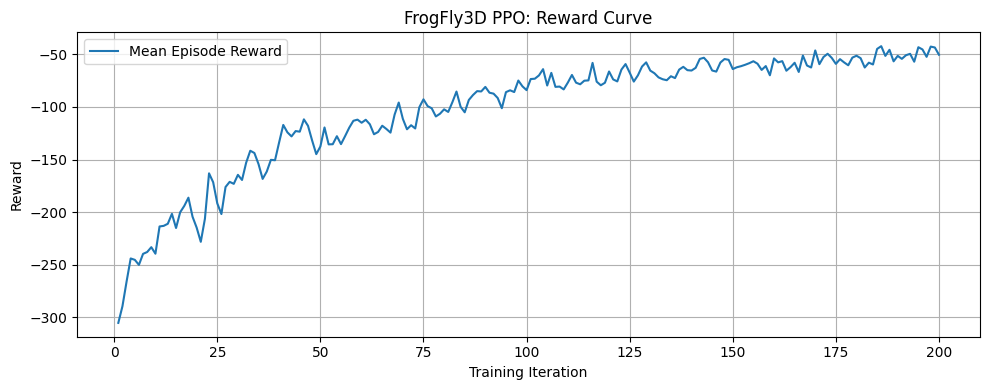

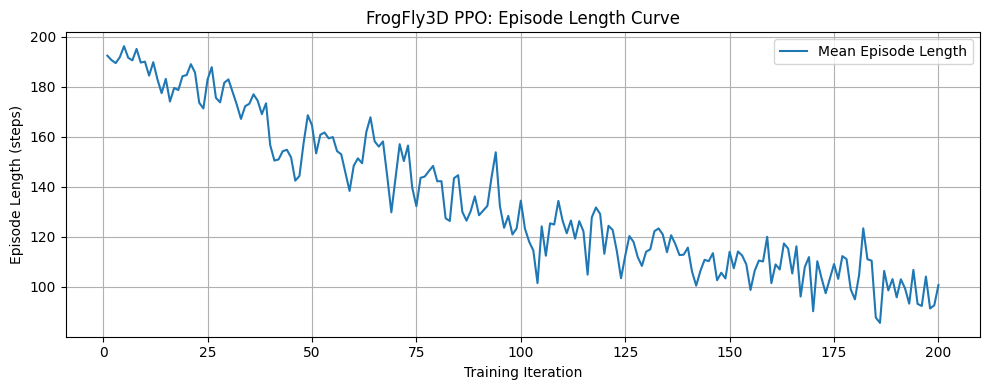

In [7]:
iters = np.arange(1, len(mean_rewards) + 1)

plt.figure(figsize=(10, 4))
plt.plot(iters, mean_rewards, label="Mean Episode Reward")
plt.xlabel("Training Iteration")
plt.ylabel("Reward")
plt.title("FrogFly3D PPO: Reward Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(iters, mean_lengths, label="Mean Episode Length")
plt.xlabel("Training Iteration")
plt.ylabel("Episode Length (steps)")
plt.title("FrogFly3D PPO: Episode Length Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


SAC on FrogFly3DEnv (continuous)

In [8]:
from ray.rllib.algorithms.registry import ALGORITHMS

print(list(ALGORITHMS.keys()))



['APPO', 'BC', 'CQL', 'DQN', 'DreamerV3', 'IMPALA', 'IQL', 'MARWIL', 'PPO', 'SAC']


In [9]:
import ray
from ray.rllib.algorithms.sac import SACConfig

ray.shutdown()
ray.init(ignore_reinit_error=True)

env_config = {
    "space_size": 1.0,
    "step_size": 0.1,
    "fly_speed": 0.05,
    "catch_radius": 0.15,
    "max_steps": 200,
    "num_freqs": 4,
    "use_positional_encodings": True,
}

sac_config = (
    SACConfig()
    .environment(env=FrogFly3DEnv, env_config=env_config)
    .framework("torch")
    .resources(num_gpus=0)
    .training(
        gamma=0.99,
        # reuse roughly the same MLP as PPO
        model={
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
        },
    )
)

sac_algo = sac_config.build()
print("SAC algo built OK")


2025-12-02 23:06:15,378	INFO worker.py:2023 -- Started a local Ray instance.
2025-12-02 23:06:15,960	WARNING algorithm_config.py:5058 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
2025-12-02 23:06:15,960	WARNING sac.py:491 -- You are running SAC on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/opt/anaconda3/envs/rl-project/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:525: RayDeprecat

SAC algo built OK


In [10]:
num_sac_iters = 200

sac_mean_rewards = []
sac_mean_lengths = []

for i in range(num_sac_iters):
    result = sac_algo.train()

    if "env_runners" in result:
        env_metrics = result["env_runners"]
        mean_r = env_metrics.get("episode_return_mean", float("nan"))
        mean_l = env_metrics.get("episode_len_mean", float("nan"))
    else:
        mean_r = result.get("episode_reward_mean", float("nan"))
        mean_l = result.get("episode_len_mean", float("nan"))

    sac_mean_rewards.append(mean_r)
    sac_mean_lengths.append(mean_l)

    print(
        f"SAC iter {i+1:03d} | "
        f"reward_mean = {mean_r:.3f} | "
        f"len_mean = {mean_l:.2f}"
    )


SAC iter 001 | reward_mean = -243.717 | len_mean = 200.00
SAC iter 002 | reward_mean = -262.813 | len_mean = 200.00
SAC iter 003 | reward_mean = -270.512 | len_mean = 200.00
SAC iter 004 | reward_mean = -258.879 | len_mean = 200.00
SAC iter 005 | reward_mean = -270.480 | len_mean = 200.00
SAC iter 006 | reward_mean = -284.820 | len_mean = 200.00
SAC iter 007 | reward_mean = -253.972 | len_mean = 182.56
SAC iter 008 | reward_mean = -253.972 | len_mean = 182.56


(pid=gcs_server) [2025-12-02 23:06:44,686 E 12011 65232737] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


SAC iter 009 | reward_mean = -264.073 | len_mean = 184.30


(raylet) [2025-12-02 23:06:45,323 E 12015 65232830] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(pid=12022) [2025-12-02 23:06:45,833 E 12022 65233103] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-02 23:06:45,978 E 11711 65232880] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


SAC iter 010 | reward_mean = -264.073 | len_mean = 184.30
SAC iter 011 | reward_mean = -267.789 | len_mean = 185.73
SAC iter 012 | reward_mean = -267.789 | len_mean = 185.73
SAC iter 013 | reward_mean = -276.950 | len_mean = 186.92
SAC iter 014 | reward_mean = -276.950 | len_mean = 186.92
SAC iter 015 | reward_mean = -265.111 | len_mean = 187.92
SAC iter 016 | reward_mean = -265.111 | len_mean = 187.92
SAC iter 017 | reward_mean = -261.118 | len_mean = 188.79
SAC iter 018 | reward_mean = -261.118 | len_mean = 188.79
SAC iter 019 | reward_mean = -257.606 | len_mean = 189.53
SAC iter 020 | reward_mean = -257.606 | len_mean = 189.53
SAC iter 021 | reward_mean = -240.189 | len_mean = 180.88
SAC iter 022 | reward_mean = -240.189 | len_mean = 180.88
SAC iter 023 | reward_mean = -240.161 | len_mean = 181.94
SAC iter 024 | reward_mean = -240.161 | len_mean = 181.94
SAC iter 025 | reward_mean = -236.647 | len_mean = 182.89
SAC iter 026 | reward_mean = -236.647 | len_mean = 182.89
SAC iter 027 |

In [11]:
# fresh env for evaluation
record_env = FrogFly3DEnv(env_config)

sac_policy = trained_policy_factory(sac_algo)

frog_sac, fly_sac = rollout_trajectory(
    record_env,
    policy_fn=sac_policy,
    max_steps=200,
)

make_3d_gif(
    frog_sac,
    fly_sac,
    out_path="frog_fly_sac.gif",
    title="SAC Frog vs Fly (Continuous)",
)

print("Saved GIF: frog_fly_sac.gif")


Saved GIF: frog_fly_sac.gif


In [12]:
from ray.rllib.algorithms.impala import IMPALAConfig

ray.shutdown()
ray.init(ignore_reinit_error=True)

impala_config = (
    IMPALAConfig()
    .environment(env=FrogFly3DEnv, env_config=env_config)
    .framework("torch")
    .resources(num_gpus=0)
    .env_runners(
        num_env_runners=1,
        # you can tune this; smaller = more frequent updates, larger = more throughput
        rollout_fragment_length=100,
    )
    .training(
        gamma=0.99,
        lr=3e-4,
        train_batch_size=2048,   # or omit if this complains; defaults will kick in
        model={
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
        },
    )
)

impala_algo = impala_config.build()
print("IMPALA algo built OK")



2025-12-02 23:25:36,435	INFO worker.py:2023 -- Started a local Ray instance.
2025-12-02 23:25:37,112	WARNING algorithm_config.py:5058 -- You are running IMPALA on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/opt/anaconda3/envs/rl-project/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/opt/anaconda3/envs/rl-project/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API

IMPALA algo built OK


In [13]:
num_impala_iters = 200

impala_mean_rewards = []
impala_mean_lengths = []

for i in range(num_impala_iters):
    result = impala_algo.train()

    if "env_runners" in result:
        env_metrics = result["env_runners"]
        mean_r = env_metrics.get("episode_return_mean", float("nan"))
        mean_l = env_metrics.get("episode_len_mean", float("nan"))
    else:
        mean_r = result.get("episode_reward_mean", float("nan"))
        mean_l = result.get("episode_len_mean", float("nan"))

    impala_mean_rewards.append(mean_r)
    impala_mean_lengths.append(mean_l)

    print(
        f"IMPALA iter {i+1:03d} | "
        f"reward_mean = {mean_r:.3f} | "
        f"len_mean = {mean_l:.2f}"
    )


IMPALA iter 001 | reward_mean = -273.999 | len_mean = 189.23
IMPALA iter 002 | reward_mean = -283.671 | len_mean = 192.99


(pid=gcs_server) [2025-12-02 23:26:05,748 E 12126 65243476] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-02 23:26:06,376 E 12131 65243576] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(SingleAgentEnvRunner pid=12138) [2025-12-02 23:26:06,952 E 12138 65243824] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-02 23:26:07,128 E 11711 65243625] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent

IMPALA iter 003 | reward_mean = -287.475 | len_mean = 194.00
IMPALA iter 004 | reward_mean = -277.502 | len_mean = 190.41
IMPALA iter 005 | reward_mean = -293.977 | len_mean = 194.03
IMPALA iter 006 | reward_mean = -288.660 | len_mean = 192.89
IMPALA iter 007 | reward_mean = -311.685 | len_mean = 195.38
IMPALA iter 008 | reward_mean = -316.579 | len_mean = 191.75
IMPALA iter 009 | reward_mean = -318.160 | len_mean = 194.92
IMPALA iter 010 | reward_mean = -304.728 | len_mean = 192.94
IMPALA iter 011 | reward_mean = -309.811 | len_mean = 195.30
IMPALA iter 012 | reward_mean = -301.100 | len_mean = 194.19
IMPALA iter 013 | reward_mean = -321.853 | len_mean = 195.62
IMPALA iter 014 | reward_mean = -299.508 | len_mean = 184.31
IMPALA iter 015 | reward_mean = -327.025 | len_mean = 197.22
IMPALA iter 016 | reward_mean = -307.410 | len_mean = 193.99
IMPALA iter 017 | reward_mean = -314.591 | len_mean = 195.38
IMPALA iter 018 | reward_mean = -316.150 | len_mean = 195.36
IMPALA iter 019 | reward

In [14]:
# fresh env for evaluation
record_env = FrogFly3DEnv(env_config)

impala_policy = trained_policy_factory(impala_algo)

frog_impala, fly_impala = rollout_trajectory(
    record_env,
    policy_fn=impala_policy,
    max_steps=200,
)

make_3d_gif(
    frog_impala,
    fly_impala,
    out_path="frog_fly_impala.gif",
    title="IMPALA Frog vs Fly (Continuous)",
)

print("Saved GIF: frog_fly_impala.gif")


Saved GIF: frog_fly_impala.gif


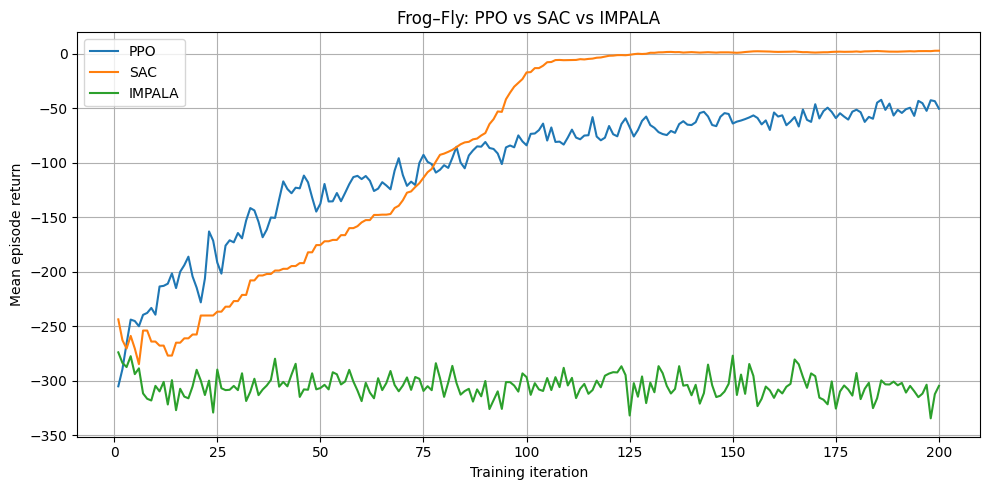

In [15]:
import matplotlib.pyplot as plt
import numpy as np

iters_ppo = np.arange(1, len(mean_rewards) + 1)
iters_sac = np.arange(1, len(sac_mean_rewards) + 1)
iters_imp = np.arange(1, len(impala_mean_rewards) + 1)

plt.figure(figsize=(10, 5))
plt.plot(iters_ppo, mean_rewards, label="PPO")
plt.plot(iters_sac, sac_mean_rewards, label="SAC")
plt.plot(iters_imp, impala_mean_rewards, label="IMPALA")
plt.xlabel("Training iteration")
plt.ylabel("Mean episode return")
plt.title("Frog–Fly: PPO vs SAC vs IMPALA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


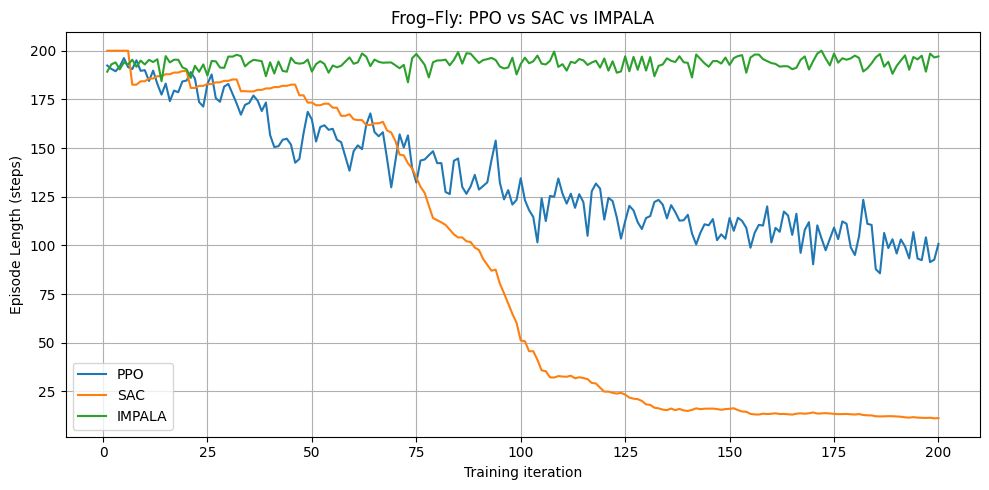

In [16]:
import matplotlib.pyplot as plt
import numpy as np

iters_ppo = np.arange(1, len(mean_lengths) + 1)
iters_sac = np.arange(1, len(sac_mean_lengths) + 1)
iters_imp = np.arange(1, len(impala_mean_lengths) + 1)

plt.figure(figsize=(10, 5))
plt.plot(iters_ppo, mean_lengths, label="PPO")
plt.plot(iters_sac, sac_mean_lengths, label="SAC")
plt.plot(iters_imp, impala_mean_lengths, label="IMPALA")
plt.xlabel("Training iteration")
plt.ylabel("Episode Length (steps)")
plt.title("Frog–Fly: PPO vs SAC vs IMPALA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Reinforcement Learning Algorithms (PPO, SAC, IMPALA)

---

### Proximal Policy Optimization (PPO)

Probability ratio:

$$
r_t(\theta) =
\dfrac{\pi_\theta(a_t|s_t)}
{\pi_{\theta_{\text{old}}}(a_t|s_t)}
$$

Advantage estimate:

$$
A_t = \sum_{k=0}^{T-t} \gamma^k r_{t+k} - V_\phi(s_t)
$$

Clipped PPO objective:

$$
J(\theta) =
\mathbb{E}_t\Big[
\min(
r_t(\theta)A_t,\,
\text{clip}(r_t(\theta),1-\epsilon,1+\epsilon)A_t
)\Big]
$$

Value regression loss:

$$
L_V(\phi)=\mathbb{E}_t[(V_\phi(s_t)-R_t)^2]
$$

---

### Soft Actor–Critic (SAC)

Maximum entropy policy objective:

$$
J(\theta) =
\mathbb{E}_{(s_t,a_t)\sim\mathcal{D}}
\Big[
Q_\phi(s_t,a_t) - \alpha \log \pi_\theta(a_t|s_t)
\Big]
$$

Soft Bellman backup:

$$
Q_\phi(s_t,a_t)=
r_t + \gamma\,\mathbb{E}_{a_{t+1}\sim\pi}
\Big[
Q_\phi(s_{t+1},a_{t+1})
- \alpha \log \pi(a_{t+1}|s_{t+1})
\Big]
$$

---

### IMPALA (V-Trace Off-Policy Correction)

V-trace return:

$$
v_t = V(s_t) +
\sum_{k=t}^{t+n-1}
\gamma^{k-t}
\Bigg(
\prod_{i=t}^{k-1} c_i
\Bigg)
\delta_k
$$

TD error with clipped importance ratio:

$$
\delta_t =
\rho_t \Big(
r_t + \gamma V(s_{t+1}) - V(s_t)
\Big)
$$

Importance sampling ratios:

$$
\rho_t = \frac{\pi(a_t|s_t)}{\mu(a_t|s_t)}, \qquad
c_t = \min(1,\rho_t)
$$
